In [12]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm, gpytorch
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# test - toy

## 1D

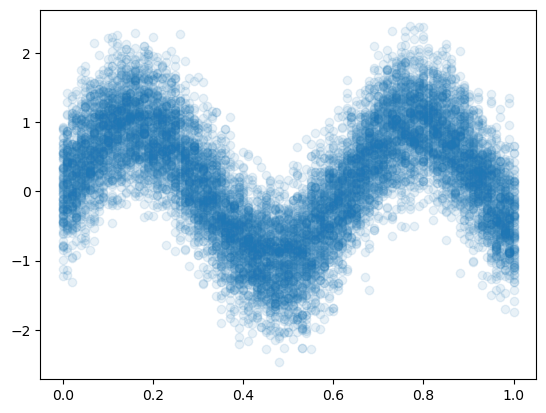

In [90]:
x1, x2 = np.meshgrid(np.linspace(0,1,101), np.linspace(0,1,101))
toy_x = x1.reshape(-1,1)
toy_y = np.sin(toy_x.reshape(-1) * 10) + np.random.normal(0, 0.5, size=toy_x.shape[0])
plt.scatter(toy_x.reshape(-1), toy_y, alpha=0.1)

In [92]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
mask = np.zeros_like(toy_y).astype(bool)
mask[:1000] = True
np.random.seed(100)
np.random.shuffle(mask)
gpr.fit(toy_x[mask], toy_y[mask])

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=10)

In [112]:
x = np.linspace(0,1,500)
p_avg, p_std = gpr.predict(x.reshape(-1,1), True)

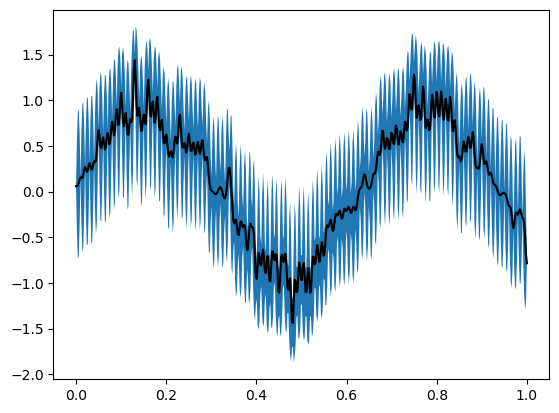

In [113]:
plt.fill_between(x, p_avg - p_std, p_avg+p_std)
plt.plot(x, p_avg, 'k')

## 2D

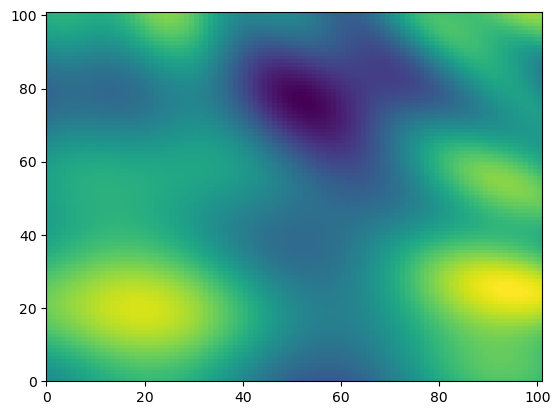

In [155]:
x1, x2 = np.meshgrid(np.linspace(0,1,101), np.linspace(0,1,101))
toy_x = np.hstack([x1.reshape(-1, 1), x2.reshape(-1, 1)])
toy_y = (np.cos(x1.reshape(-1) * np.pi * 2) + 
        np.sin(x1.reshape(-1) * np.pi * 3 - 7) * 2 + 
        np.cos(x2.reshape(-1) * np.pi * 5 - 3) + 
        np.sin(x2.reshape(-1) * np.pi * 2) * 2 + 
        np.cos(x2.reshape(-1) * x1.reshape(-1) * np.pi * 8) 
) #+ np.random.normal(0, 0.5, toy_x.shape[0])
plt.pcolormesh(toy_y.reshape(101,101))

In [161]:
kernel = RBF(length_scale=10, length_scale_bounds=(1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.001, n_restarts_optimizer=10)
mask = np.zeros_like(toy_y).astype(bool)
mask[:200] = True
np.random.seed(100)
np.random.shuffle(mask)
gpr.fit(toy_x[mask], toy_y[mask])

GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=10),
                         n_restarts_optimizer=10)

In [162]:
N = 50
x = np.hstack([x.reshape(-1,1) for x in np.meshgrid(np.linspace(0,1,N), np.linspace(0,1,N))])
p_avg, p_std = gpr.predict(x, True)

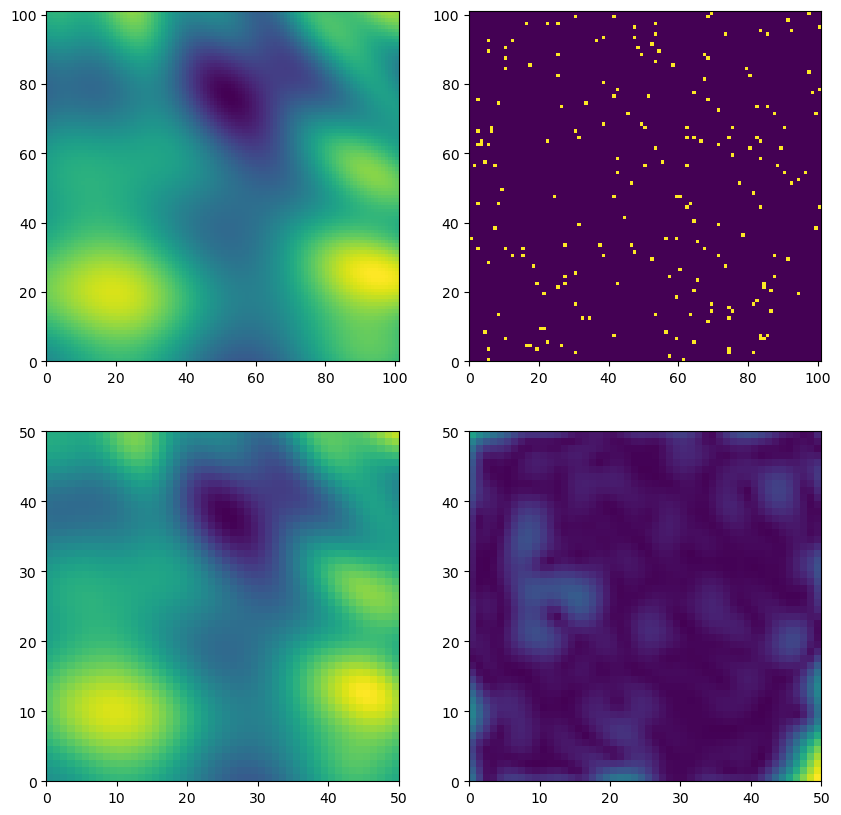

In [163]:
f, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].pcolormesh(toy_y.reshape(101,101))
axs[0,1].pcolormesh(mask.reshape(101,101))
axs[1,0].pcolormesh(p_avg.reshape(N,N))
axs[1,1].pcolormesh(p_std.reshape(N,N))

- gp

In [164]:
class SingleGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.shape[0])
        variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

ttoy_x = torch.from_numpy(toy_x).float()
ttoy_y = torch.from_numpy(toy_y).float()
train_dl = DataLoader([[x,y] for x,y in zip(ttoy_x[:8000], ttoy_y[:8000])], batch_size=256)
test_dl = DataLoader([[x,y] for x,y in zip(ttoy_x[8000:], ttoy_y[8000:])], batch_size=2048)

mask = np.zeros(toy_y.shape[0]).astype(bool)
mask[:2000] = True
np.random.shuffle(mask)
mask[8000:] = False

model = SingleGPModel(ttoy_x[mask]).to('cuda')
likelihood = gpytorch.likelihoods.GaussianLikelihood().to('cuda')

vopt = gpytorch.optim.NGD(model.variational_parameters(), num_data=8000,
                          lr=0.01)
popt = torch.optim.Adam([{'params':model.parameters(), 'params':likelihood.parameters()}], 
                        lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=8000)

for i in range(2000):
    train_loss = 0
    model.train()
    likelihood.train()

    for X, Y in train_dl:
        vopt.zero_grad()
        popt.zero_grad()

        out = model(X.cuda())
        loss = -mll(out, Y.cuda())
#        print(loss)
        loss.backward()
#        vopt.step()
        popt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    likelihood.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for X, Y in test_dl:

            pred = model(X.cuda())
            test_loss += -mll(pred, Y.cuda()).cpu().item()

            err = pred.mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(
        i, train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.hstack(errs)).mean()))

  0      5.81529      4.88627      2.07156
  1      5.12176      4.38251      2.07156
  2      4.62607      4.02348      2.07156
  3      4.26640      3.75939      2.07156


KeyboardInterrupt: 

- nn

# test - synthesis

## dataset

In [2]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_single_source_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'),
               heat_time_key=('heat_time','median'))

In [211]:
years = np.array([d.year for d in GDSM])
train_mask = years > 2017
test_idx = np.where(train_mask)[0]
train_idx = np.where(~train_mask)[0]
inducing_idx = np.random.permutation(train_idx)[:3000]

feat, _ = GDSM.cfn(GDSM)
target_feat = feat['target_feat']
temp_label, time_label = feat['condition_feat'].T
train_dl = DataLoader(GDSM, batch_size=1024, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=1024, sampler=test_idx, collate_fn=GDSM.cfn)

In [226]:
class SingleGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.shape[0])
        variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = SingleGPModel(target_feat[train_mask]).to('cuda')
likelihood = gpytorch.likelihoods.GaussianLikelihood().to('cuda')
target_mean = temp_label[train_mask].mean()
target_std = temp_label[train_mask].std()

vopt = gpytorch.optim.NGD(model.variational_parameters(), num_data=len(train_idx),
                          lr=0.01)
popt = torch.optim.Adam([{'params':model.parameters(), 'params':likelihood.parameters()}], 
                        lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_idx))

for i in range(2000):
    train_loss = 0
    model.train()
    likelihood.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = (batch['condition_feat'][:, 0].to('cuda') - target_mean) / target_std
        vopt.zero_grad()
        popt.zero_grad()

        out = model(X)
        loss = -mll(out, Y)
        print(loss)
        loss.backward()
        vopt.step()
#        popt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    likelihood.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = (batch['condition_feat'][:, 0].to('cuda') - target_mean) / target_std

            pred = model(X)
            test_loss += -mll(pred, Y).cpu().item()

            err = pred.mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(
        i, train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.hstack(errs)).mean()))

tensor(1.8765, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1211.7301, device='cuda:0', grad_fn=<NegBackward0>)
tensor(10335001., device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.8061e+10, device='cuda:0', grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [193]:
out = model(target_feat.cuda())
llh = likelihood(target_feat.cuda())

In [203]:
out.mean.cpu().detach() * target_std + target_mean, temp_label

(tensor([0.2859, 0.2859, 0.2859,  ..., 0.2861, 0.2865, 0.2863]),
 tensor([ 0.4732,  0.2482,  0.1107,  ...,  0.3731, -0.3119,  0.7232]))

In [138]:
#out = model(torch.vstack([d.target_feat for d in GDSM]).cuda())
g = gaussian_kde(out.mean.detach().cpu().numpy())
#x = np.linspace(-1,1,100)
#plt.plot(x, g(x))

0.002115923

In [4]:
model_outputs = {}

In [14]:
from src.networks import FCNNBlock

crit = torch.nn.GaussianNLLLoss()
model = FCNNBlock(input_dim=91, output_dim=2, batch_norm=False, dropout=0.5)
model.to('cuda')
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
measures = []
best_loss = 1e5
for i in range(200):
    train_loss = 0
    model.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = batch['condition_feat'].to('cuda')[:, 1:]
        opt.zero_grad()
        out = model(X)
        mean, var = torch.chunk(out, 2, -1)
        var = torch.abs(var)
        loss = crit(mean, Y, var)
        loss.backward()
        opt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = batch['condition_feat'].to('cuda')[:, 1:]

            out = model(X)
            mean, var = torch.chunk(out, 2, -1)
            var = torch.abs(var)
            test_loss += crit(mean, Y, var).cpu().item()
            err = mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    measure = [train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.vstack(errs)).mean()]
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(i, *measure))
    measures.append(measure)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model.state_dict()


  0      7.11621      0.30482      0.38185
  1      2.98774     -0.10902      0.37932
  2      1.89940     -0.12591      0.37613
  3      2.05274     -0.17010      0.37735
  4      1.32810     -0.10179      0.37946
  5      1.76062      2.64723      0.37901
  6      3.26257      3.45413      0.38247
  7      1.90164      1.62757      0.38156
  8      1.44354      0.96708      0.37790
  9      2.59315     -0.22902      0.38348
 10      0.36187     -0.22931      0.38524
 11      0.15544     -0.22994      0.38542
 12      0.14313     -0.22939      0.38518
 13      0.16215     -0.22761      0.38523
 14      0.10805     -0.22586      0.38563
 15      0.17701     -0.22670      0.38525
 16      2.79231     -0.21248      0.38796
 17     -0.04910     -0.20139      0.38740
 18      0.09632     -0.19160      0.38743
 19     -0.05829     -0.19381      0.38699
 20     -0.07328     -0.19287      0.38681
 21     -0.06269     -0.19535      0.38693
 22     -0.02984     -0.19221      0.38648
 23     -0.

In [11]:
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    pred = model(GDSM.cfn(GDSM)[0]['target_feat'].to('cuda'))
mean, var = torch.chunk(pred, 2, -1)
model_outputs['both_temp'] = mean.cpu().numpy()[:, 0], np.abs(var.cpu().numpy())[:, 0]
model_outputs['both_time'] = mean.cpu().numpy()[:, 1], np.abs(var.cpu().numpy())[:, 1]

In [15]:
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    pred = model(GDSM.cfn(GDSM)[0]['target_feat'].to('cuda'))
mean, var = torch.chunk(pred, 2, -1)
model_outputs['sing_time'] = mean.cpu().numpy().reshape(-1), np.abs(var.cpu().numpy().reshape(-1))

In [16]:
with open('../dump/gaussian.ouput.pkl','rb') as f:
    model_outputs = pickle.load(f)

In [17]:
inp_vecs = torch.vstack([d.target_feat for d in GDSM])
dist = torch.cdist(inp_vecs, inp_vecs)

In [119]:
mask = dist.numpy() < 1e-2
idxs = []
for i in np.where(mask.sum(1) > 50)[0]:
    j = np.argmin(dist[i]).item()
    if j not in idxs:
        idxs.append(j)
#    if (mask[j] != mask[i]).sum() != 0:
#        idxs.append(i)
len(idxs)

298

In [97]:
values = {}
for i in torch.where(dist[0] < 3e-2)[0]:
    tstr = composit_parser(GDSM[i].target_comp)
    if tstr not in values.keys():
        values[tstr] = {'pred':{k:(v[0][i], v[1][i]) for k,v in model_outputs.items()}, 'vals':[]}
    values[tstr]['vals'].append(GDSM[i].condition_feat.numpy())


In [79]:
t1, t2 = np.vstack([d.condition_feat.numpy() for d in GDSM]).T

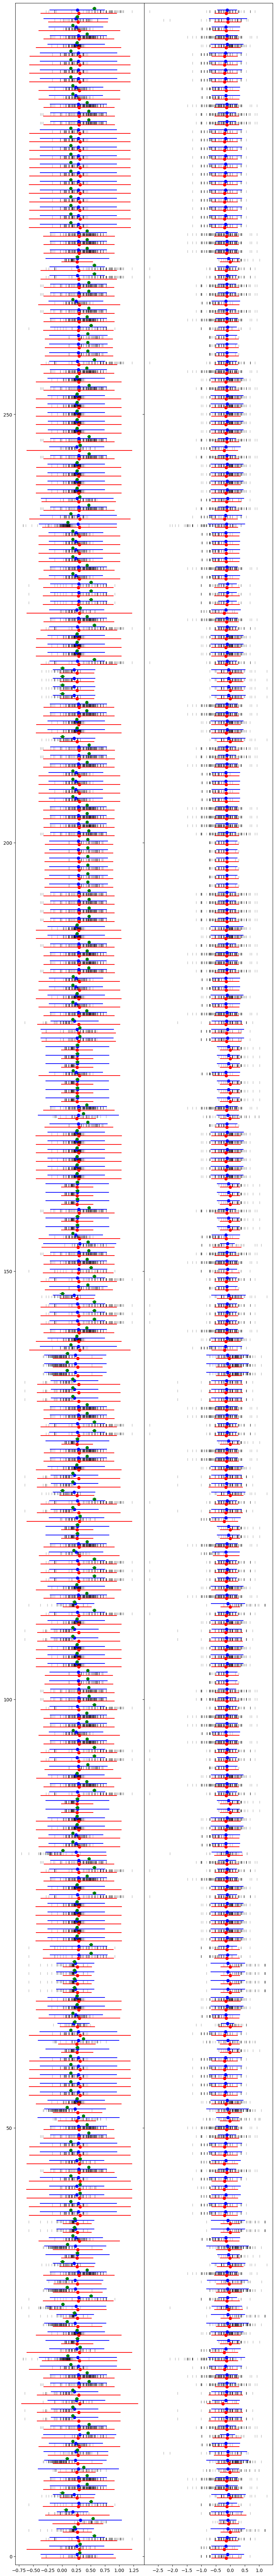

In [156]:
f, axs = plt.subplots(1,2,figsize=(10,100), sharey=True)
for i,idx in enumerate(idxs):
    axs[0].errorbar(model_outputs['both_temp'][0][idx], [i-0.2], xerr=model_outputs['both_temp'][1][idx], color='r', marker='o')
    axs[0].errorbar(model_outputs['sing_temp'][0][idx], [i+0.2], xerr=model_outputs['sing_temp'][1][idx], color='b', marker='o')
    axs[0].errorbar(skgpr_out_mean[idx], [i+0.4], xerr=skgpr_out_std[idx], color='g', marker='o')
    axs[0].scatter(t1[mask[idx]], [i]*mask[idx].sum(), color='k', marker='|', alpha=0.2)
    axs[1].errorbar(model_outputs['both_time'][0][idx], [i-0.2], xerr=model_outputs['both_time'][1][idx], color='r', marker='o')
    axs[1].errorbar(model_outputs['sing_time'][0][idx], [i+0.2], xerr=model_outputs['sing_time'][1][idx], color='b', marker='o')
    axs[1].scatter(t2[mask[idx]], [i]*mask[idx].sum(), color='k', marker='|', alpha=0.2)
axs[0].set_ylim(-1, len(idxs))
f.subplots_adjust(wspace=0)

In [143]:
target_feat = np.vstack([d.target_feat.numpy() for d in GDSM])
condition_feat = np.vstack([d.condition_feat.numpy() for d in GDSM])

In [145]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1.0, n_restarts_optimizer=10)
gpr.fit(target_feat, condition_feat[:, 0])

GaussianProcessRegressor(alpha=1.0, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [148]:
skgpr_out_mean, skgpr_out_std = gpr.predict(target_feat, return_std=True)

In [149]:
with open('../dump/sklearn_gpr.model_and_output.pkl','wb') as f:
    pickle.dump([gpr, skgpr_out_mean, skgpr_out_std], f)

In [153]:
model_outputs['both_temp'][0].shape, skgpr_out_mean

((31600,), (31600,))

In [ ]:
class RBFKernel(torch.nn.Module):
    def __init__(self, input_dim):
        super(RBFKernel, self).__init__()
        self.input_dim = input_dim
        self.variance = torch.nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.lengthscale = torch.nn.Parameter(torch.randn(input_dim).abs(), requires_grad=True)

    def forward(self, x1, x2=None):
        # Compute the squared Euclidean distance between x1 and x2
        x1 = x1 / self.lengthscale
        x1s = torch.pow(x1, 2).sum(1)

        if x2 is None: 
            dist = -2 * x1.mm(x1.T) + x1s.view(-1,1) + x1s.view(1,-1)
        else:
            x2 = x2 / self.lengthscale
            x2s = torch.pow(x2, 2).sum(1)
            dist = -2 * x1.mm(x2.T) + x1s.view(-1,1) + x2s.view(1,-1)

        # Compute the kernel matrix
        kernel_matrix = self.variance * torch.exp(-0.5 * dist)

        return kernel_matrix


In [59]:
torch.abs(torch.randn(10))

tensor([1.2797, 0.5692, 0.6242, 1.7780, 0.7217, 0.8491, 0.5731, 0.8418, 0.6193,
        0.3363])

In [76]:
x = torch.rand(256, 91)

In [74]:
def f1(x):
    return torch.pow(torch.cdist(x, x), 2)

def f2(x):
    xs = torch.pow(x, 2).sum(1)
    return -2 * x.mm(x.T) + xs.view(1,-1) + xs.view(-1,1)

%timeit f1(x)
%timeit f2(x)

39.3 µs ± 92 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
23.1 µs ± 31.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
f1(x) - f2(x)

tensor([[ 0.0000e+00, -1.9073e-06, -1.9073e-06,  ...,  1.9073e-06,
         -5.7220e-06,  0.0000e+00],
        [-1.9073e-06,  0.0000e+00, -4.7684e-06,  ..., -1.9073e-06,
          0.0000e+00, -2.8610e-06],
        [-1.9073e-06, -4.7684e-06,  7.6294e-06,  ..., -1.9073e-06,
         -1.9073e-06,  0.0000e+00],
        ...,
        [-1.9073e-06, -1.9073e-06,  1.9073e-06,  ...,  0.0000e+00,
         -1.9073e-06, -1.9073e-06],
        [-5.7220e-06,  0.0000e+00, -1.9073e-06,  ..., -1.9073e-06,
          0.0000e+00,  9.5367e-07],
        [ 0.0000e+00, -2.8610e-06,  0.0000e+00,  ..., -1.9073e-06,
          9.5367e-07,  3.8147e-06]], device='cuda:0')

# check distribution of conditions - temp & time

In [ ]:
from sklearn.manifold import TSNE

tvec = TSNE().fit_transform(feat.numpy())
tx, ty = tvec.T
y1, y2 = label.numpy().T

In [166]:
g1x, g1y, g1z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-1,2,15))]
g2x, g2y, g2z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-3,2,15))]

In [168]:
import plotly.express as px
g1 = gaussian_kde(np.vstack([tx, ty, y1]))
c1 = g1(np.vstack([g1x, g1y, g1z]))
px.scatter_3d(x=g1x, y=g1y, z=g1z, color=c1, opacity=0.8, size=c1, size_max=40, height=800)

In [170]:
g2 = gaussian_kde(np.vstack([tx, ty, y2]))
c2 = g2(np.vstack([g2x, g2y, g2z]))
px.scatter_3d(x=g2x, y=g2y, z=g2z, color=c2, opacity=0.9, size=c2, size_max=30, height=800)